In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [2]:
%pip install git+https://github.com/fkunstner/dataset-downloader.git

Note: you may need to restart the kernel to use updated packages.Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Cloning https://github.com/fkunstner/dataset-downloader.git to c:\users\root\appdata\local\temp\pip-req-build-a4fs36qr
  Resolved https://github.com/fkunstner/dataset-downloader.git to commit 44e1689ee298d6fa62b7cf6097b39656447e244a
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'



  Running command git clone --filter=blob:none --quiet https://github.com/fkunstner/dataset-downloader.git 'C:\Users\root\AppData\Local\Temp\pip-req-build-a4fs36qr'


In [3]:
import dsdl

ds = dsdl.load("w1a")

X_train, y_train = ds.get_train()
print(X_train.shape, y_train.shape)

X_train = X_train.toarray()

X_test, y_test = ds.get_test()
print(X_test.shape, y_test.shape)

X_test = X_test.toarray()

(2477, 300) (2477,)
(47272, 300) (47272,)


In [4]:
print(np.max(X_train))
print(np.min(X_train))
print(np.unique(X_train))
print(np.unique(y_train))
print(np.sum(X_train))
print(np.sum(y_train))
print(np.sum(X_test))
print(np.sum(y_test))

1.0
0.0
[0. 1.]
[-1.  1.]
28410.0
-2333.0
551176.0
-44458.0


## Deterministic GD
Dataset: w1a

We investigate the dependence of the convergence rate on the clipping parameter c.

In [5]:
def sigmoid(z):
  return 1 / (1 + np.exp(-z))

def logloss(y_true, y_pred):
  epsilon=1e-15
  y_pred = np.clip(y_pred, epsilon, 1 - epsilon)

  log_loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
  return log_loss


def gradient_dw(x, y, w):
  '''In this function, we will compute the gardient w.r.to w ''' 
  # print((sigmoid(np.matmul(x,w)) - y).T.shape)
  # print(x.shape)
  # print(np.matmul((sigmoid(np.matmul(x,w)) - y).T, x).shape)

  # dw = np.matmul((sigmoid(np.matmul(x,w)) - y).T, x) / len(y)
  if(type(y) is np.float64):
    gradient = np.dot(x.T, (sigmoid(np.matmul(x,w) - y)))
  else:
    gradient = np.dot(x.T, (sigmoid(np.matmul(x,w) - y))) / len(y)
  return gradient

In [6]:
np.random.seed(seed = 42)

w = np.random.rand(300)

print(w.max())
z = sigmoid(np.matmul(X_train, w))
gradient_dw(X_train, y_train, w).max()
logloss(y_train, z)

0.9900538501042633


10.920605187791885

In [7]:
def clipping(c, u):
    if np.linalg.norm(u) == 0:
        return u
    else:
        return min(1, c / (np.linalg.norm(u))) * u

In [8]:
from sklearn.metrics import log_loss

def DGD(X, y, w_0, c, eps = 0.01, lr = 10, iterations = 200):
    """
    Perform Deterministic GD
    X - features         (dataset_size, feature_num) [0, 1]
    y - labels           (dataset_size, )            either -1 or 1
    w_0 - init weights   (feature_num, )              
    c - clipping parameters(array)
    eps - target grad norm
    lr - learning rate

    returns 
    w - final weights;
    norms - norms of the gradients
    """
    w = []
    w_k = w_0.copy()
    
    norms = np.zeros((len(c), iterations))
    for ind in range(len(c)):
        w_k = w_0.copy()
        loss = 1000
        for iter in range(iterations):

            grad = gradient_dw(X, y, w_k)   
            norms[ind][iter] = np.linalg.norm(grad)
            if(c[ind]):
                grad = clipping(c[ind], grad)
            
            w_k = w_k - (lr * grad)
            loss = min(loss, log_loss(y, sigmoid(np.matmul(X, w_k))))
            
            # print("Iteration:", iter, "Loss:", loss, "Norm:", np.linalg.norm(grad))
        # if(c[ind]):
        #     print("norms_unique for ind =", ind, np.unique(norms[ind]))
        w.append(w_k)
        print("c =", c[ind], "grad_min =", np.min(norms[ind]))
        
    
    return norms, w

In [9]:
w_0 = np.random.rand(X_test.shape[1]) * 0.01
c = [0, 0.1, 0.01, 0.001]
lr = 10
iterations = 200
eps = 0.01

norms, w = DGD(X_test, y_test, w_0, c, eps, lr, iterations)

print("MIN|MAX|mean W's")
for i in w:
    print(min(i), max(i), np.mean(i))

c = 0 grad_min = 0.002512730514814683
c = 0.1 grad_min = 0.0026896583729764537
c = 0.01 grad_min = 0.0034854057961859457
c = 0.001 grad_min = 0.16663072376729776
MIN|MAX|mean W's
-3.571035423951317 0.008846295427169772 -0.6607290403839731
-3.3536376076872907 0.00848957652508755 -0.6276257808378665
-3.1213967613709652 0.008488254060388212 -0.5537979790405583
-0.6347335425137942 0.009603993967460337 -0.0631492632148931


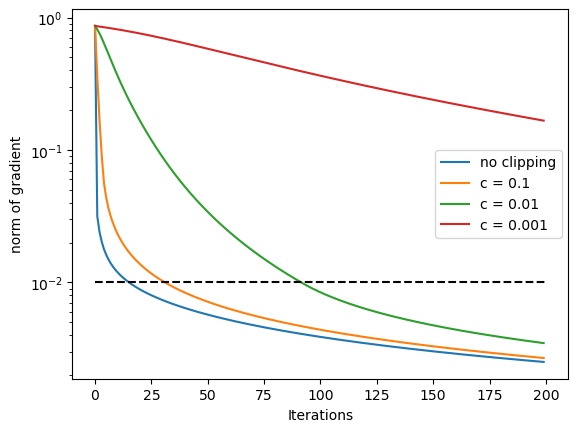

In [10]:
# plt.figure(figsize = (9, 3))

plt.plot(norms[0], label = "no clipping")
plt.plot(norms[1], label = "c = 0.1")
plt.plot(norms[2], label = "c = 0.01")
plt.plot(norms[3], label = "c = 0.001")
plt.hlines(0.01, xmin=0, xmax=iterations, linestyles='dashed', colors='black')
plt.yscale('log')
plt.xlabel("Iterations")
plt.ylabel("norm of gradient")
plt.legend()

In [11]:
w_0 = np.random.rand(X_test.shape[1]) * 0.01
c = [0, 0.1, 0.01, 0.001, 0.0001]
lr = 10
iterations = 5000
eps = 0.01

norms, w = DGD(X_test, y_test, w_0, c, eps, lr, iterations)

print("MIN|MAX W's")
for i in w:
    print(min(i), max(i))

c = 0 grad_min = 0.00022494365480928873
c = 0.1 grad_min = 0.0002263624103108834
c = 0.01 grad_min = 0.00022871963950004404
c = 0.001 grad_min = 0.00032640542887280336
c = 0.0001 grad_min = 0.03409826400939574
MIN|MAX W's
-5.97188281882347 0.0077171796405223324
-5.972766455392086 0.00735599979765821
-5.96127007628439 0.00733673238018595
-5.54935315646576 0.007340256065453294
-1.4557886354782907 0.007988118662491333


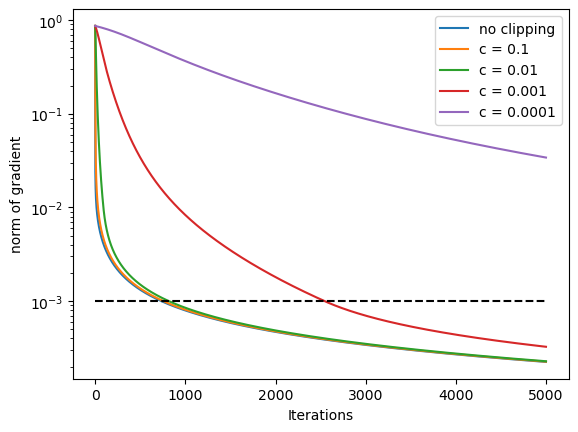

In [12]:
# plt.figure(figsize = (9, 3))

plt.plot(norms[0], label = "no clipping")
plt.plot(norms[1], label = "c = 0.1")
plt.plot(norms[2], label = "c = 0.01")
plt.plot(norms[3], label = "c = 0.001")
plt.plot(norms[4], label = "c = 0.0001")
plt.yscale('log')
plt.hlines(0.001, xmin=0, xmax=iterations, linestyles='dashed', colors='black')
plt.xlabel("Iterations")
plt.ylabel("norm of gradient")
plt.legend()

In [13]:
w_0 = np.random.rand(X_test.shape[1]) * 0.01
iterations = 50
eps = 0.01

lr = 0.5
c = [0]
norms0, w = DGD(X_test, y_test, w_0, c, eps, lr, iterations)
print("MIN|MAX W's")
for i in w:
    print(min(i), max(i))

lr = 133
c = [0.1]
norms1, w = DGD(X_test, y_test, w_0, c, eps, lr, iterations)
print("MIN|MAX W's")
for i in w:
    print(min(i), max(i))

lr = 233
c = [0.01]
norms2, w = DGD(X_test, y_test, w_0, c, eps, lr, iterations)
print("MIN|MAX W's")
for i in w:
    print(min(i), max(i))

lr = 1000
c = [0.001]
norms3, w = DGD(X_test, y_test, w_0, c, eps, lr, iterations)
print("MIN|MAX W's")
for i in w:
    print(min(i), max(i))

c = 0 grad_min = 0.058997372125176625
MIN|MAX W's
-1.1530699205759627 0.008792791244770148
c = 0.1 grad_min = 0.0010340120024832987
MIN|MAX W's
-4.703162036244948 0.007904483031520538
c = 0.01 grad_min = 0.0007512653111824668
MIN|MAX W's
-4.634964446070811 0.007818943820599486
c = 0.001 grad_min = 0.0003313961493960387
MIN|MAX W's
-5.571100174060715 0.007867337690252843


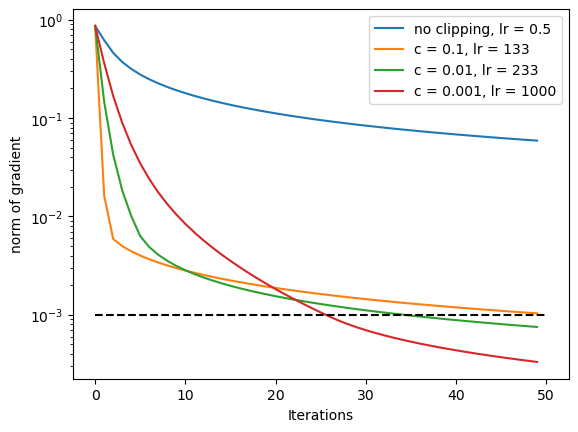

In [14]:
plt.plot(norms0[0], label = "no clipping, lr = 0.5")
plt.plot(norms1[0], label = "c = 0.1, lr = 133")
plt.plot(norms2[0], label = "c = 0.01, lr = 233")
plt.plot(norms3[0], label = "c = 0.001, lr = 1000")
plt.yscale('log')
plt.hlines(0.001, xmin=0, xmax=iterations, linestyles='dashed', colors='black')
plt.xlabel("Iterations")
plt.ylabel("norm of gradient")
plt.legend()

In [15]:
def generate_batches(X, y, batch_size):
    """
    Generate batches of data from the input features X and labels y.

    Parameters:
    - X: Input features
    - y: Labels
    - batch_size: Size of each batch

    Returns:
    - X_batched: List of batches of input features
    - y_batched: List of batches of labels
    """
    n = len(X)
    num_batches = n // batch_size
    X_batched = []
    y_batched = []

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size
        X_batch = X[start_idx:end_idx]
        y_batch = y[start_idx:end_idx]
        X_batched.append(X_batch)
        y_batched.append(y_batch)

    # If there are remaining data points, include them in the final batch
    if n % batch_size != 0:
        # print("Warning: there are", n % batch_size, "remaining data points that are not included in batches")
        start_idx = num_batches * batch_size
        X_batch = X[start_idx:]
        y_batch = y[start_idx:]
        X_batched.append(X_batch)
        y_batched.append(y_batch)

    return X_batched, y_batched


# # Example usage:
batch_size = 32
X_batched, y_batched = generate_batches(X_train, y_train, batch_size)

print(len(X_batched),
len(X_batched[0]),
len(X_batched[0][0]))
print(len(y_batched),
      len(y_batched[0]))

78 32 300
78 32


In [16]:
def SGD(X, y, w_0, c = 0.1, eps = 0.01, lr = 10., iterations = 100000):
    """
    Perform Deterministic GD
    X - features         (dataset_size, feature_num) [0, 1]
    y - labels           (dataset_size, )            either -1 or 1
    w_0 - init weights   (feature_num, )              
    c - clipping parameters(array)
    eps - target grad norm
    lr - learning rate(array)

    returns 
    w - final weights;
    norms - norms of the gradients
    """
    w = []
    w_k = w_0.copy()
    
    loss = 1000
    w_k = w_0.copy()
    norms = np.zeros(iterations)
    
    batches = np.random.randint(low=0, high=len(y), size=iterations)
    for iter in range(iterations):
        ind = batches[iter]

        grad = gradient_dw(X[ind], y[ind], w_k)   
        norms[iter] = np.linalg.norm(grad)

        if(c):
            grad = clipping(c, grad)

        w_k = w_k - (lr * grad)
        loss = min(loss, logloss(y[ind], sigmoid(np.matmul(X[ind], w_k))))

        w.append(w_k)
        if not (iter % 5000):
            print(".", end="")
    # if(c[ind]):
    #     print("norms_unique for ind =", ind, np.unique(norms[ind]))
    
    print("c =", c, "lr =", lr, "norms_best =", np.min(norms))

    return norms, w[-1]

In [17]:
# w_0 = np.random.rand(X_test.shape[1]) * 0.01
# c = [0, 0.1, 0.01, 0.001, 0.0001]
# lr = 10
# iterations = 5000
# eps = 0.01

# norms, w = DGD(X_test, y_test, w_0, c, eps, lr, iterations)

# print("MIN|MAX W's")
# for i in w:
#     print(min(i), max(i))

w_0 = np.random.rand(X_test.shape[1]) * 0.01
w_0 = np.zeros(X_test.shape[1])

c = [0.01, 0.001]
lr = [0.1, 1, 10]
iterations = int(1e4)

batch_size = 256
X_batched, y_batched = generate_batches(X_test, y_test, batch_size)

norms = np.zeros((2,3,iterations))
for clips in range(len(c)):
    for rates in range(len(lr)):
        norms[clips][rates], w = SGD(X_batched, y_batched, w_0, c[clips], eps, lr[rates], iterations)
        print()

..c = 0.01 lr = 0.1 norms_best = 0.006163228273941942

..c = 0.01 lr = 1 norms_best = 1.65019657538274e-05

..c = 0.01 lr = 10 norms_best = 1.0124668388344625e-08

..c = 0.001 lr = 0.1 norms_best = 0.17063209496723383

..c = 0.001 lr = 1 norms_best = 0.006245819807955478

..c = 0.001 lr = 10 norms_best = 1.4410949536096448e-06



In [18]:
print(np.min(norms))
print(np.max(norms))

1.0124668388344625e-08
2.1716324377247416


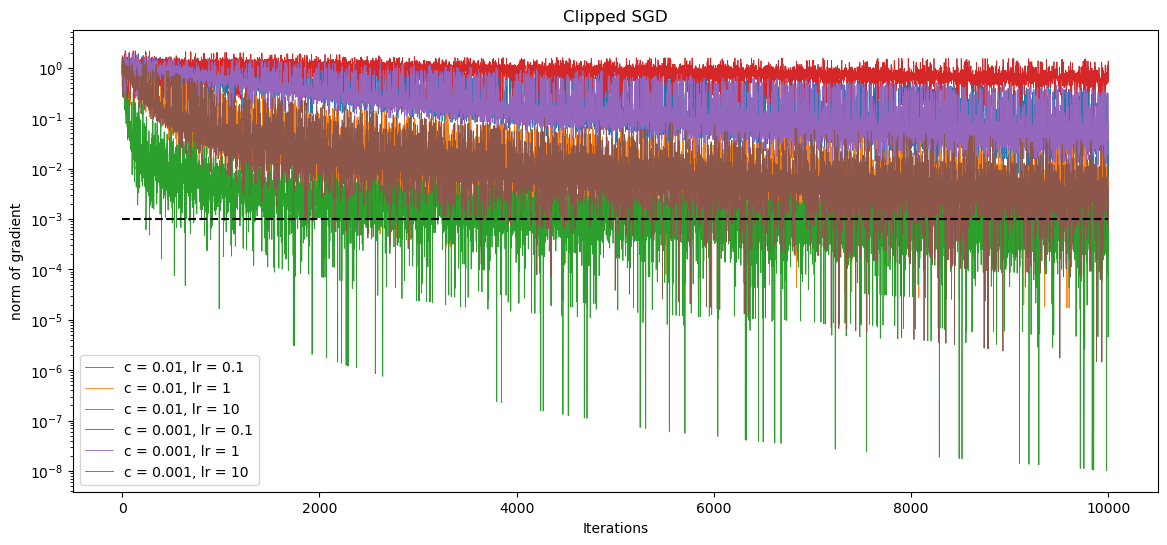

In [19]:
# plt.plot(norms0[0], label = "no clipping, lr = 0.5")
# plt.plot(norms1[0], label = "c = 0.1, lr = 133")
# plt.plot(norms2[0], label = "c = 0.01, lr = 233")
# plt.plot(norms3[0], label = "c = 0.001, lr = 1000")
# plt.yscale('log')

plt.figure(figsize=(14, 6))

for clips in range(len(c)):
    for rates in range(len(lr)): 
        label = "c = " + str(c[clips]) + ", lr = " + str(lr[rates])
        plt.plot(norms[clips][rates], label=label, linewidth=0.6)  # Adjust linewidth
plt.hlines(0.001, xmin=0, xmax=iterations, linestyles='dashed', colors='black')
plt.title("Clipped SGD")
plt.xlabel("Iterations")
plt.ylabel("norm of gradient")
plt.yscale('log')
plt.legend()
plt.show()

In [20]:
w_0 = np.random.rand(X_test.shape[1]) * 0.01
w_0 = np.zeros(X_test.shape[1])

c = [0]
lr = [0.1, 1, 10]
iterations = int(1e4)

batch_size = 256
X_batched, y_batched = generate_batches(X_test, y_test, batch_size)

norms = np.zeros((2,3,iterations))
for clips in range(len(c)):
    for rates in range(len(lr)):
        norms[clips][rates], w = SGD(X_batched, y_batched, w_0, c[clips], eps, lr[rates], iterations)
        print()

..c = 0 lr = 0.1 norms_best = 0.0005284003082934647

..c = 0 lr = 1 norms_best = 1.0443047274810775e-05

..c = 0 lr = 10 norms_best = 8.688385114667962e-09



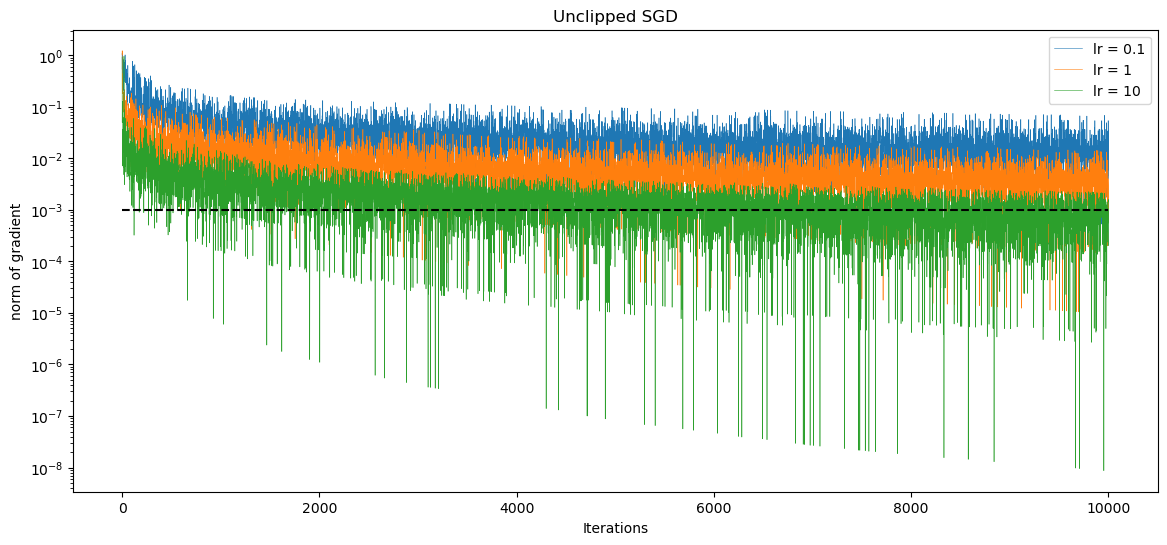

In [21]:
plt.figure(figsize=(14, 6))

for clips in range(len(c)):
    for rates in range(len(lr)): 
        label = "lr = " + str(lr[rates])
        plt.plot(norms[clips][rates], label=label, linewidth=0.4)  # Adjust linewidth

plt.xlabel("Iterations")
plt.ylabel("norm of gradient")
plt.hlines(0.001, xmin=0, xmax=iterations, linestyles='dashed', colors='black')
plt.title("Unclipped SGD")
plt.yscale('log')
plt.legend()
plt.show()

In [24]:
w_0 = np.random.rand(X_test.shape[1]) * 0.01
w_0 = np.zeros(X_test.shape[1])

c = [0]
lr = [0.1, 0.01, 0.001]
iterations = int(1e5)

batch_size = 256
X_batched, y_batched = generate_batches(X_test, y_test, batch_size)

norms = np.zeros((2,3,iterations))
for clips in range(len(c)):
    for rates in range(len(lr)):
        norms[clips][rates], w = SGD(X_batched, y_batched, w_0, c[clips], eps, lr[rates], iterations)
        print()

....................c = 0 lr = 0.1 norms_best = 8.815359009304869e-06

....................c = 0 lr = 0.01 norms_best = 0.0005302938945048534

....................c = 0 lr = 0.001 norms_best = 0.006785362274793763



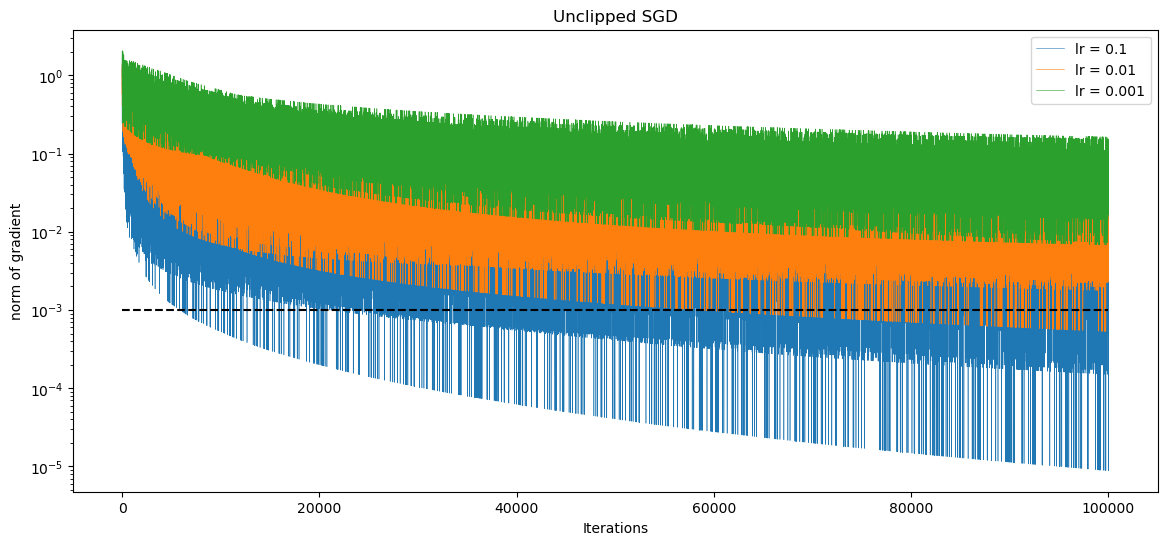

In [25]:
plt.figure(figsize=(14, 6))

for clips in range(len(c)):
    for rates in range(len(lr)): 
        label = "lr = " + str(lr[rates])
        plt.plot(norms[clips][rates], label=label, linewidth=0.4)  # Adjust linewidth

plt.xlabel("Iterations")
plt.ylabel("norm of gradient")
plt.hlines(0.001, xmin=0, xmax=iterations, linestyles='dashed', colors='black')
plt.title("Unclipped SGD")
plt.yscale('log')
plt.legend()
plt.show()